## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [17]:
def print_graphs(data):
    for i in range(0, 21, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 21, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 21, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [18]:
data = np.load("datasets/avi/single/data_sub1.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.T
data.shape

(4, 21, 15360)


(15360, 21, 4)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

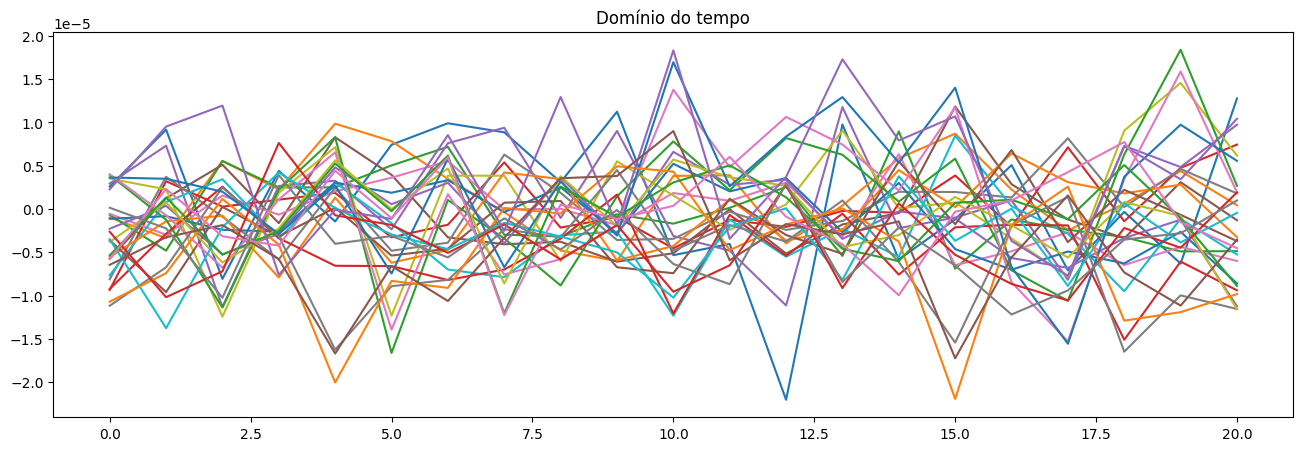

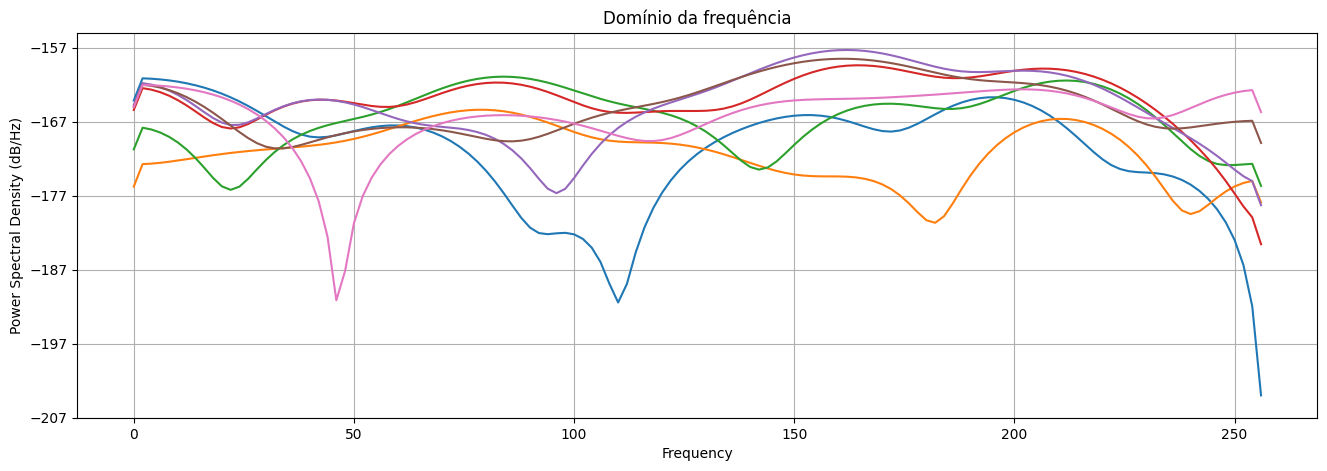

C:\Users\caio-\AppData\Local\Temp\ipykernel_2820\1856478781.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=21).
  plt.specgram(data[i,:], Fs=512)


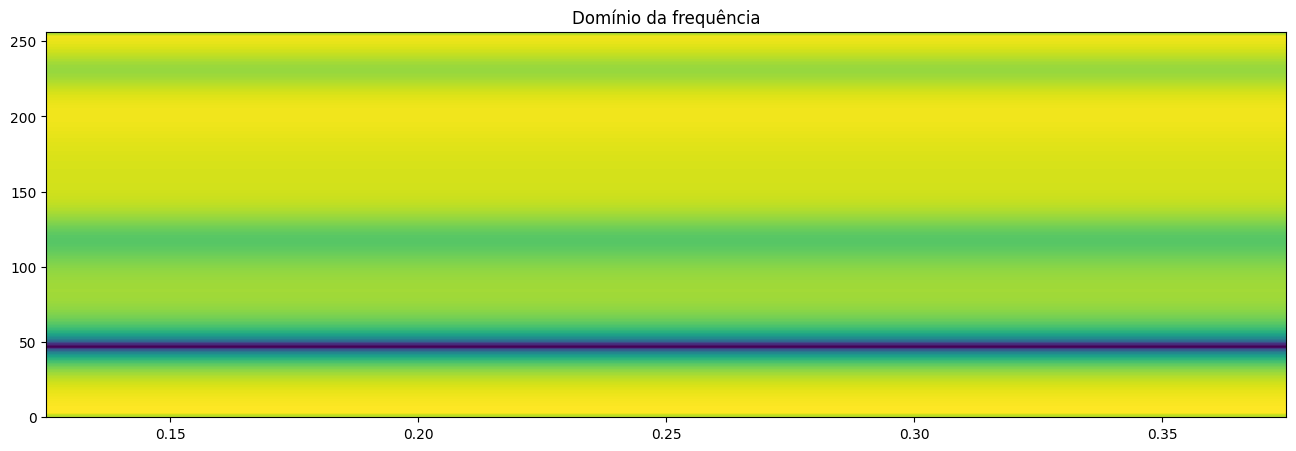

In [19]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [20]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [21]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("datasets/avi/single/labels_sub1.npy")[0]
print(labels, labels.shape)

[[10. ]
 [10. ]
 [10. ]
 [ 6.5]
 [ 6.5]
 [ 6.5]
 [ 6. ]
 [ 6. ]
 [ 6. ]
 [ 7.5]
 [ 7.5]
 [ 7.5]
 [ 7. ]
 [ 7. ]
 [ 7. ]
 [ 8.2]
 [ 8.2]
 [ 8.2]
 [ 9.3]
 [ 9.3]
 [ 9.3]] (21, 1)


In [39]:
for i in range(0,4):
    data = np.load("datasets/avi/single/data_sub1.npy")[i]
    data_correct = data.reshape(data.shape[0], 1, data.shape[1])
    # adicionando label como "épocas" do sinal
    labels = np.load("datasets/avi/single/labels_sub1.npy")[0]
    # método para transformar labels categóricos
    le = LabelEncoder()
    events = np.column_stack((
        np.array(range(len(labels))),
        np.zeros(21, dtype=int),
        le.fit_transform(labels))
    )
    event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
    mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
    mne_data

    #salvar fif
    mne_data.save('datasets/avi/single/sub1_run'+str(i+1)+'.fif', overwrite=True)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


In [29]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


NameError: name 'mne_data' is not defined

### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochsArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\2574818476.py:15: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=False)


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\2574818476.py:15: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=False)


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\2574818476.py:15: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=False)


IndexError: index 4 is out of bounds for axis 0 with size 4

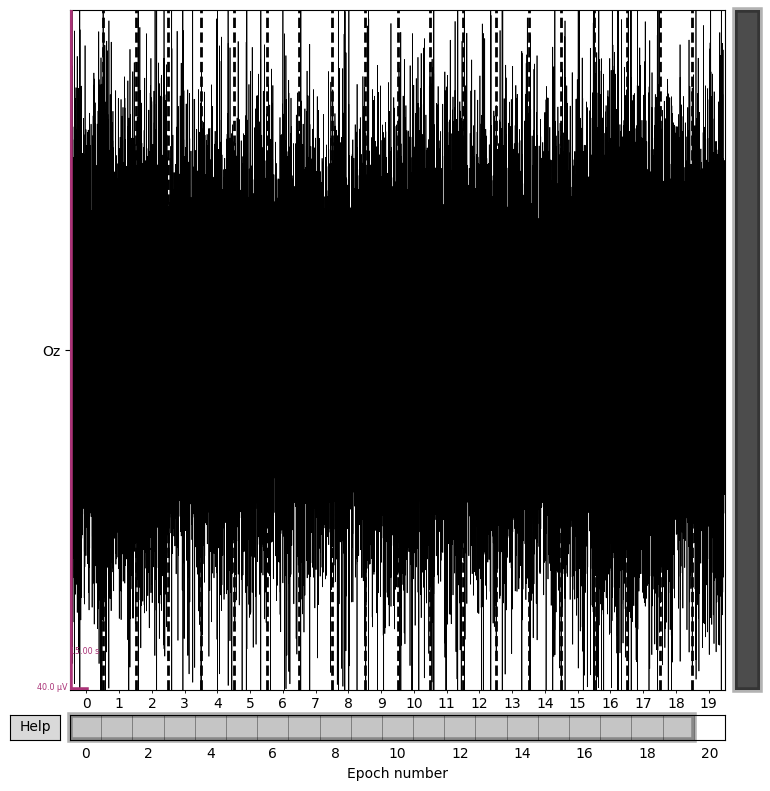

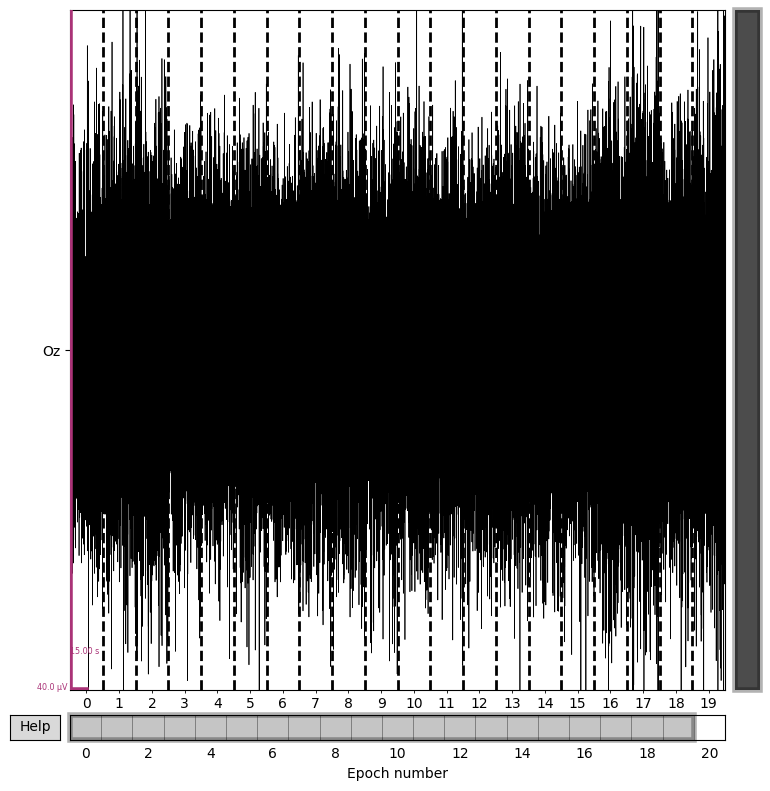

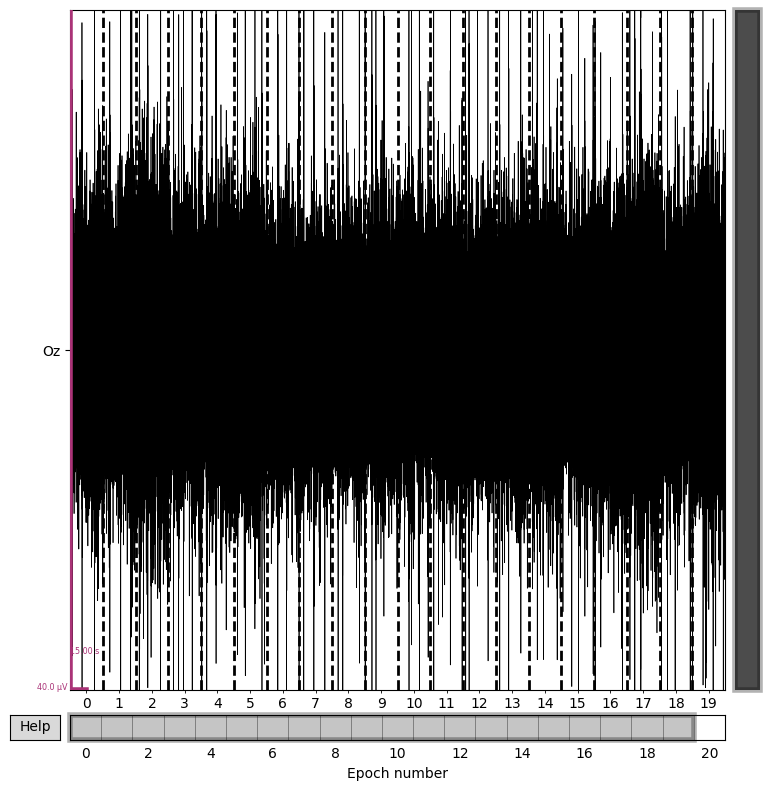

In [ ]:
mne_list = []
for i in range(1,5):
    labels = np.load("datasets/avi/single/labels_sub1.npy")[0].flatten()
    data = np.load("datasets/avi/single/data_sub1.npy")[i]

    data_correct = data.reshape(data.shape[0], 1, data.shape[1])
    le = LabelEncoder()
    events = np.column_stack((
        np.array(range(len(labels))),
        np.zeros(21, dtype=int),
        le.fit_transform(labels))
    )
    event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
    mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
    mne_data.plot(show=False)


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\1218970574.py:17: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=True)


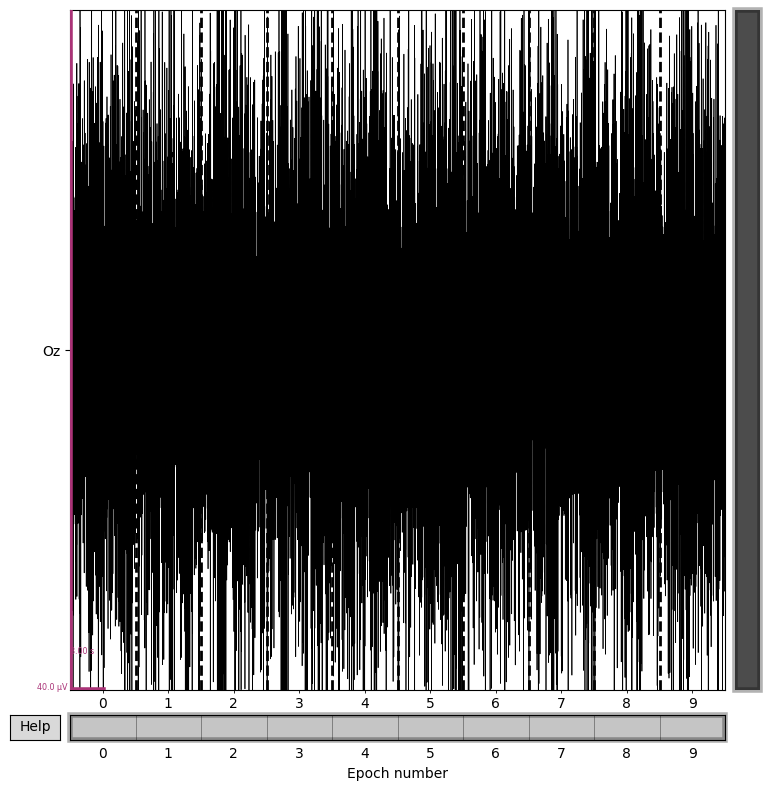

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\1218970574.py:17: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=True)


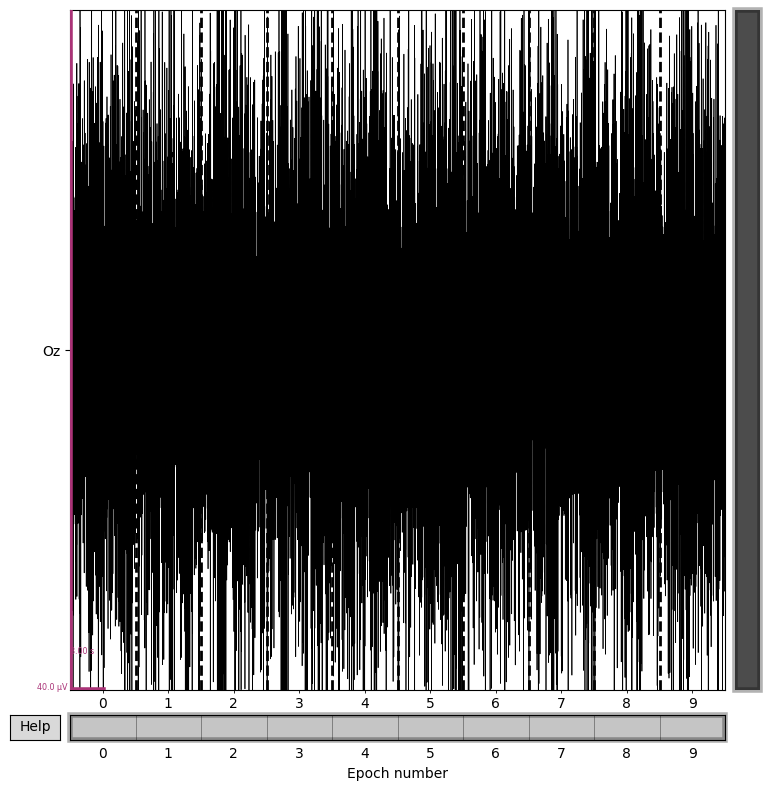

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\1218970574.py:17: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=True)


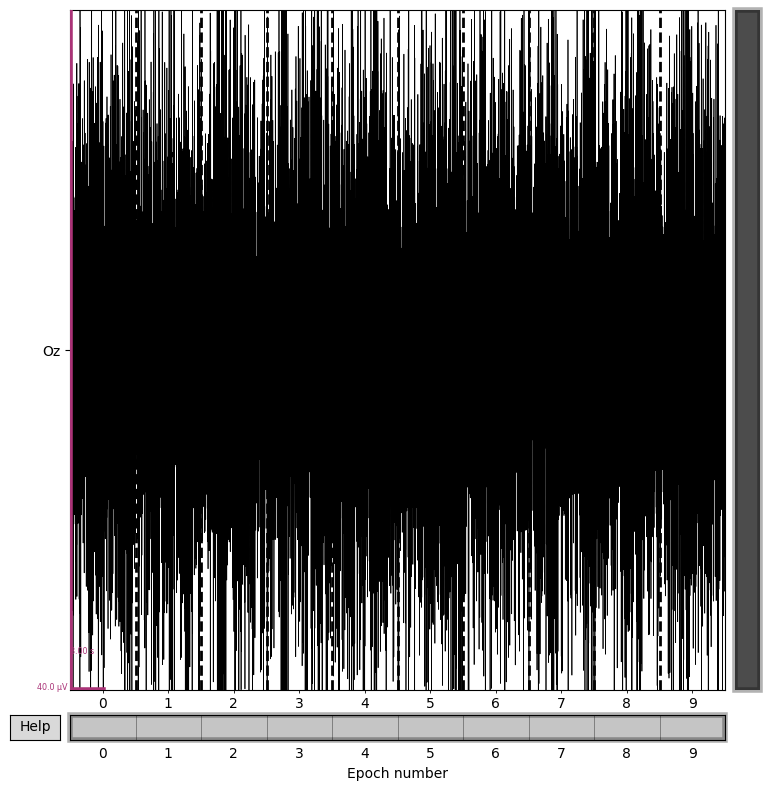

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


C:\Users\caio-\AppData\Local\Temp\ipykernel_5644\1218970574.py:17: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  mne_data.plot(show=True)


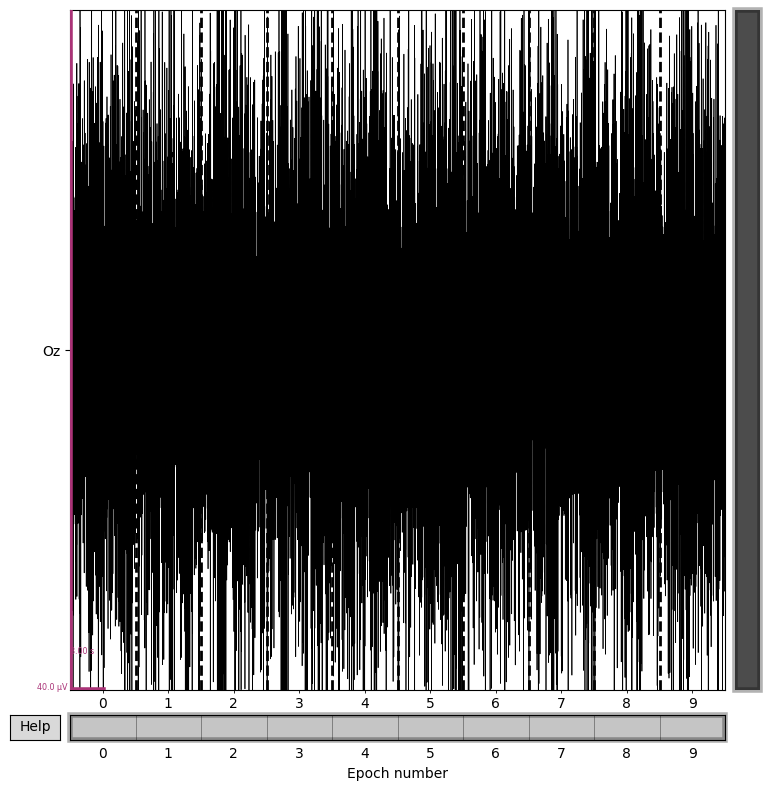

In [ ]:
mne_list = []
for i in range(1,5):
    labels = np.load("datasets/avi/multi/labels_sub1.npy")[0].flatten()
    data = np.load("datasets/avi/multi/data_sub1.npy")[0]


    data = data.T
    data_correct = data.reshape(data.shape[0], 1, data.shape[1])
    le = LabelEncoder()
    events = np.column_stack((
        np.array(range(len(labels))),
        np.zeros(10, dtype=int),
        le.fit_transform(labels))
    )
    event_dict = {'6':0, '7':1,'7.5': 2, '8.2':3}
    mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
    mne_data.plot(show=True) 